In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv("NYC_TAXI_Dataset.csv")

In [ ]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,airport_fee
0,2,2023-04-28 16:48:36,2023-04-28 16:54:09,1.0,0.62,1.0,N,140,141,2,6.5,2.5,0.5,0.00,0.00,1.0,13.00,2.5,0.0,NaN
1,2,2023-04-23 03:36:53,2023-04-23 04:04:12,1.0,10.82,1.0,N,148,67,2,45.7,1.0,0.5,0.00,0.00,1.0,50.70,2.5,0.0,NaN
2,2,2023-04-15 17:37:42,2023-04-15 17:51:00,1.0,1.03,1.0,N,90,79,1,12.8,0.0,0.5,3.36,0.00,1.0,20.16,2.5,0.0,NaN
3,1,2023-04-10 11:15:19,2023-04-10 11:25:42,1.0,1.60,1.0,N,162,140,1,11.4,2.5,0.0,3.00,0.00,1.0,17.90,2.5,0.0,NaN
4,2,2023-04-25 14:11:48,2023-04-25 15:12:14,1.0,17.05,2.0,N,100,132,2,70.0,0.0,0.5,0.00,6.55,1.0,80.55,2.5,0.0,NaN


In [10]:
df.shape

(650000, 20)

**EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               650000 non-null  int64  
 1   tpep_pickup_datetime   650000 non-null  object 
 2   tpep_dropoff_datetime  650000 non-null  object 
 3   passenger_count        650000 non-null  float64
 4   trip_distance          650000 non-null  float64
 5   RatecodeID             650000 non-null  float64
 6   store_and_fwd_flag     650000 non-null  object 
 7   PULocationID           650000 non-null  int64  
 8   DOLocationID           650000 non-null  int64  
 9   payment_type           650000 non-null  int64  
 10  fare_amount            650000 non-null  float64
 11  extra                  650000 non-null  float64
 12  mta_tax                650000 non-null  float64
 13  tip_amount             650000 non-null  float64
 14  tolls_amount           650000 non-nu

In [ ]:
print(df.isnull().sum())

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count               0
trip_distance                 0
RatecodeID                    0
store_and_fwd_flag            0
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge          0
Airport_fee                   0
airport_fee              650000
dtype: int64


In [11]:
df = df.drop("airport_fee",axis=1)

In [ ]:
print(df['payment_type'].value_counts()) #1= Credit card, 2= Cash, 3= No charge, 4= Dispute.

payment_type
1    521646
2    116153
4      7884
3      4317
Name: count, dtype: int64


In [12]:
print(df['passenger_count'].value_counts())

passenger_count
1.0    484624
2.0     98159
3.0     26210
4.0     15151
0.0     11742
5.0      8681
6.0      5427
8.0         4
7.0         1
9.0         1
Name: count, dtype: int64


In [4]:
df["passenger_count"].min()

0.0

In [13]:
numeric_df = df.select_dtypes(include='number')

for col in numeric_df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    print(f'{col}: {outliers} outliers')

VendorID: 0 outliers
passenger_count: 165376 outliers
trip_distance: 86794 outliers
RatecodeID: 37726 outliers
PULocationID: 0 outliers
DOLocationID: 0 outliers
payment_type: 128354 outliers
fare_amount: 76352 outliers
extra: 12486 outliers
mta_tax: 11771 outliers
tip_amount: 50237 outliers
tolls_amount: 54179 outliers
improvement_surcharge: 6809 outliers
total_amount: 82963 outliers
congestion_surcharge: 54974 outliers
Airport_fee: 56365 outliers


In [14]:
numeric_df = df.select_dtypes(include='number')
numeric_df = numeric_df.drop(['payment_type','passenger_count'],axis=1)

for col in numeric_df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Shape after outlier removal:", df.shape)


Shape after outlier removal: (506890, 19)


In [15]:
df = df[(df["passenger_count"] > 0)]
df = df[(df["fare_amount"] > 0)]
df = df[(df["trip_distance"] > 0)]

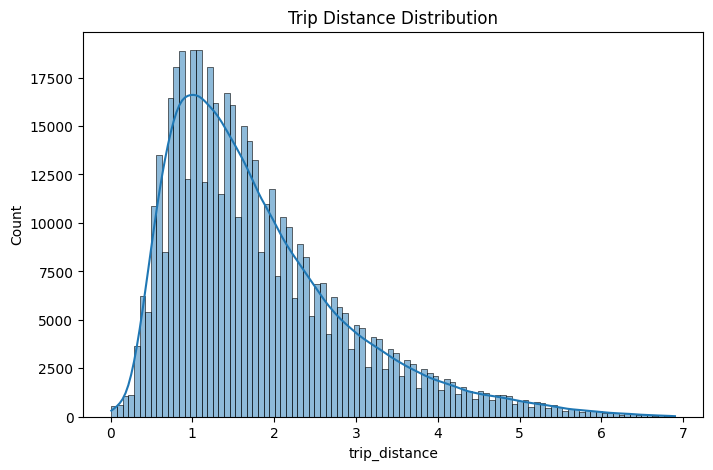

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['trip_distance'], bins=100, kde=True)
plt.title('Trip Distance Distribution')
plt.show()

It is a right Skewed graph , telling us that
Count of Trip Decreases as the Distance of the Trip Increases.
i.e. , there are lesser trips of longer distance.

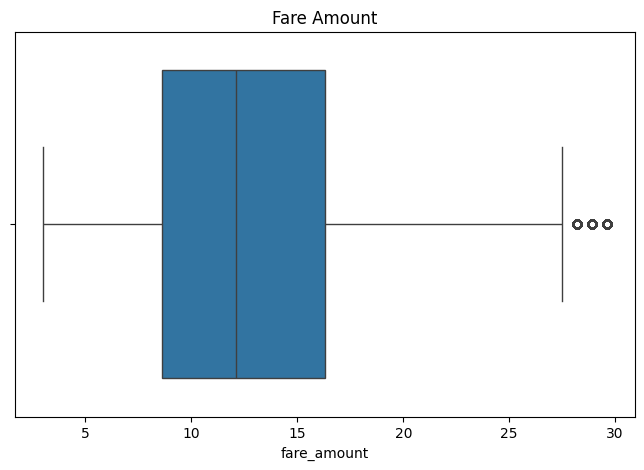

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['fare_amount'])
plt.title('Fare Amount')
plt.show()

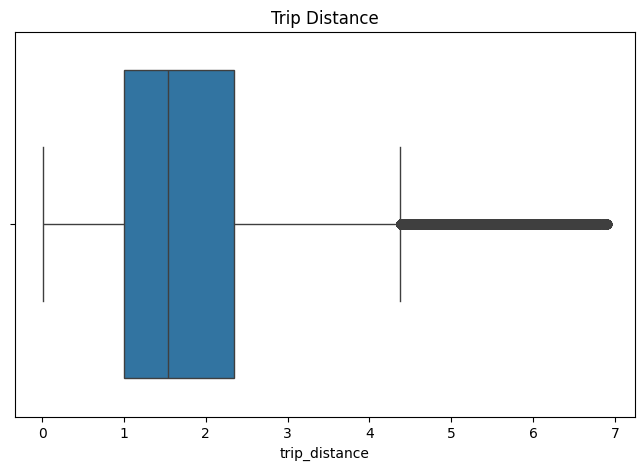

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['trip_distance'])
plt.title('Trip Distance')
plt.show()

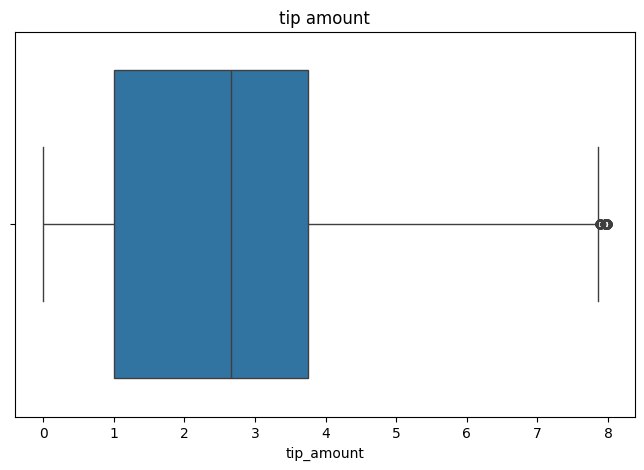

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['tip_amount'])
plt.title('tip amount')
plt.show()

Usual trip distance is between 1 - 3 kilometers/miles , very rare trips with a distance above 5 miles/kilometers.

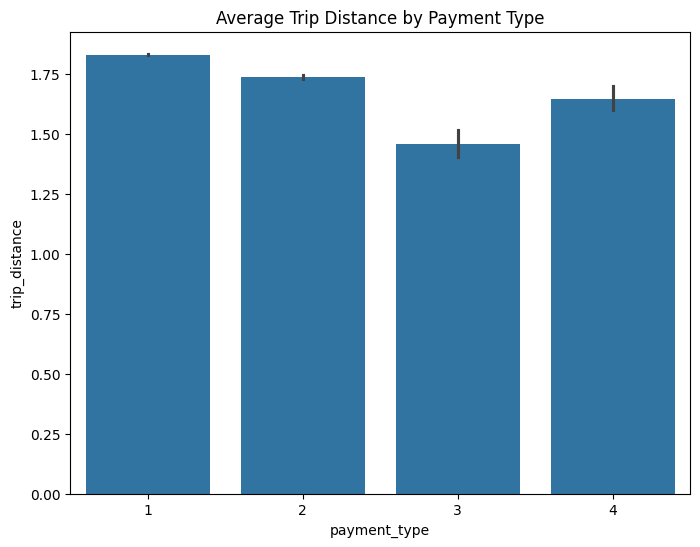

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='payment_type', y='trip_distance', data=df, estimator='mean')
plt.title('Average Trip Distance by Payment Type')
plt.show()



Payment_type: How the passenger paid for the trip, represented by a numeric code.
1. = Credit card
2. = Cash
3. = No charge
4. = Dispute

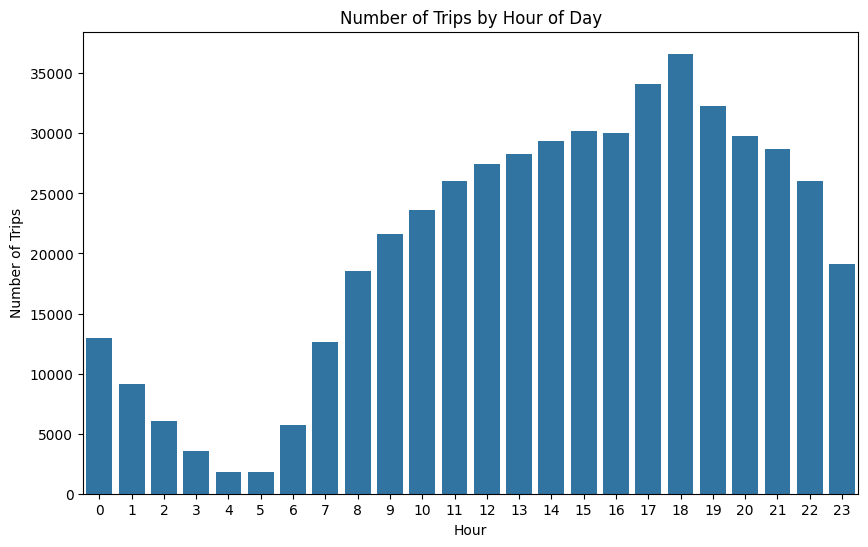

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x='hour', data=df)
plt.title('Number of Trips by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.show()


We can see that number of trips get afffected by hour , in the evening between 17:00 and 19:00 hours , the number of trips are more.
and its least in the morning around 2:00 and 5:00 hours.

In [ ]:
print(df.groupby('payment_type')['fare_amount'].describe())

                 count       mean       std  min  25%   50%   75%   max
payment_type                                                           
1             405316.0  12.852245  5.380921  3.0  8.6  12.1  16.3  29.6
2              85730.0  12.643246  5.782122  3.0  7.9  11.4  15.6  29.6
3               1677.0  10.817293  6.247806  3.0  5.8   9.3  14.9  29.6
4               2726.0  11.766434  6.363176  3.0  6.5  10.7  15.6  29.6


Average fare amount according to the number of passenger

In [ ]:
print(df.groupby('passenger_count')['fare_amount'].mean())

passenger_count
1.0    12.721551
2.0    12.977155
3.0    13.214489
4.0    13.594030
5.0    12.921214
6.0    12.972404
Name: fare_amount, dtype: float64


In [16]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['day'] = df['tpep_pickup_datetime'].dt.day
df['month'] = df['tpep_pickup_datetime'].dt.month

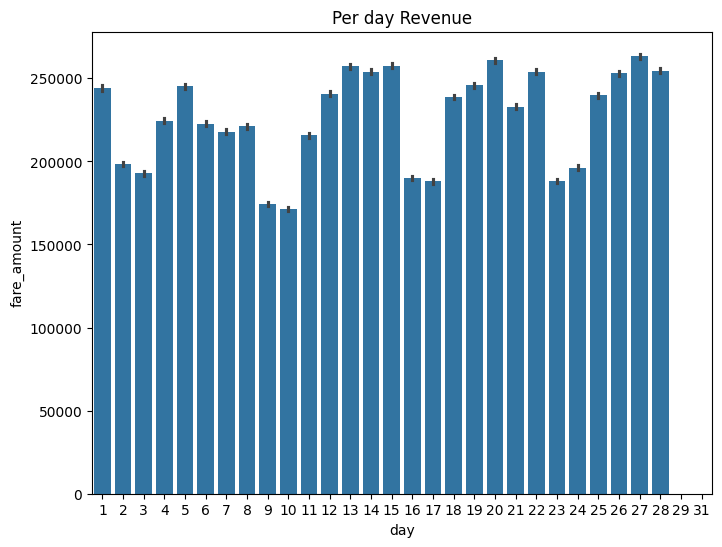

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='day', y='fare_amount', data=df,estimator="sum")
plt.title('Per day Revenue')
plt.show()

**Data Cleaning and Pre-Processing**

In [17]:
df = df.drop(["RatecodeID","mta_tax","tolls_amount","improvement_surcharge","total_amount","congestion_surcharge","VendorID","Airport_fee"],axis=1)

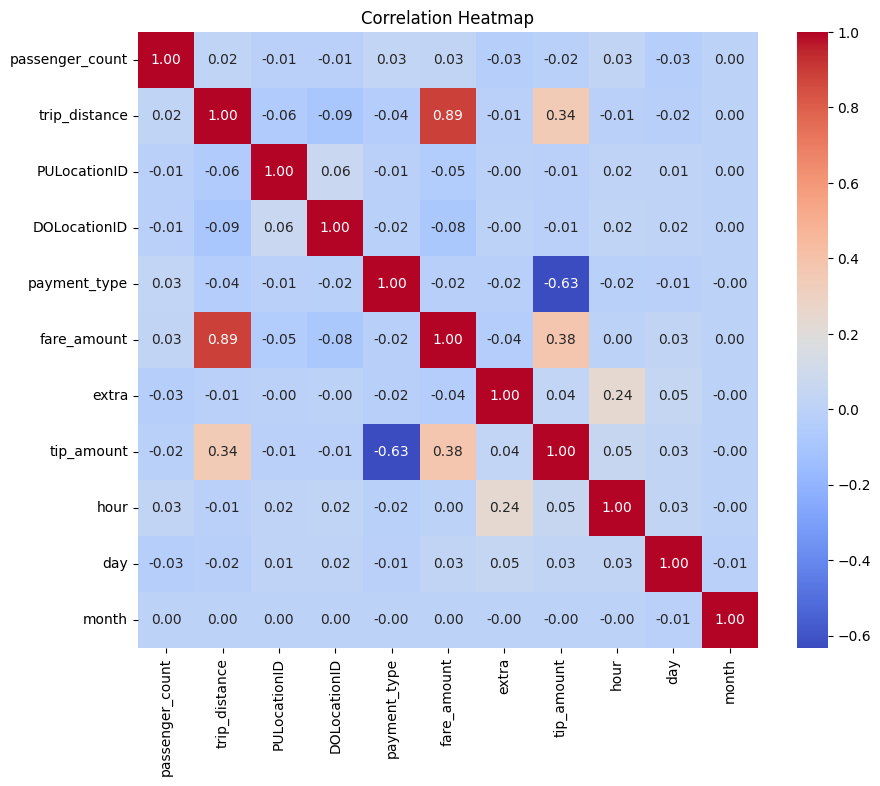

In [ ]:
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

1. We can see that trip distance has high impact on fare amount , i.e , as trip distance increases, fare amount also increases.
2. Also , as much the fare charges increases , the tip also increases gradually.
3. Payment type has a strong negative impact over the tip amount.
4. Extra Charges , are impacted by the number of hours .

In [18]:
numeric_df = df.select_dtypes(include='number')
print(numeric_df.columns)

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'tip_amount', 'hour', 'day',
       'month'],
      dtype='object')


**Feature Engineering**

Checking For multicollinearity using VIF
(Variance Inflation Factor)

In [19]:
X = add_constant(numeric_df)
X = X.drop("fare_amount",axis=1)
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

            Feature            VIF
0             const  566354.028023
1   passenger_count       1.004984
2     trip_distance       1.224606
3      PULocationID       1.007379
4      DOLocationID       1.012262
5      payment_type       1.781196
6             extra       1.065888
7        tip_amount       2.027094
8              hour       1.067536
9               day       1.005470
10            month       1.000104


In [20]:
# Creating a new column 'total_fare'
df['total_fare'] = df['fare_amount'] + df['extra']
print(df[['fare_amount', 'extra', 'total_fare']].head())

    fare_amount  extra  total_fare
0           6.5    2.5         9.0
2          12.8    0.0        12.8
6          10.7    1.0        11.7
7           5.1    1.0         6.1
10         15.6    0.0        15.6


In [ ]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,hour,day,month,total_fare
0,2023-04-28 16:48:36,2023-04-28 16:54:09,1.0,0.62,N,140,141,2,6.5,2.5,0.00,16,28,4,9.0
2,2023-04-15 17:37:42,2023-04-15 17:51:00,1.0,1.03,N,90,79,1,12.8,0.0,3.36,17,15,4,12.8
6,2023-04-14 23:48:10,2023-04-14 23:57:01,2.0,1.51,N,48,233,2,10.7,1.0,0.00,23,14,4,11.7
7,2023-04-06 23:50:32,2023-04-06 23:53:20,2.0,0.35,N,170,137,1,5.1,1.0,3.03,23,6,4,6.1
10,2023-04-15 18:03:58,2023-04-15 18:20:19,1.0,2.16,N,239,230,1,15.6,0.0,2.00,18,15,4,15.6


In [21]:
df1 = df.drop(["tpep_pickup_datetime","tpep_dropoff_datetime","store_and_fwd_flag","PULocationID","DOLocationID","day","month","fare_amount","tip_amount","extra"],axis=1)

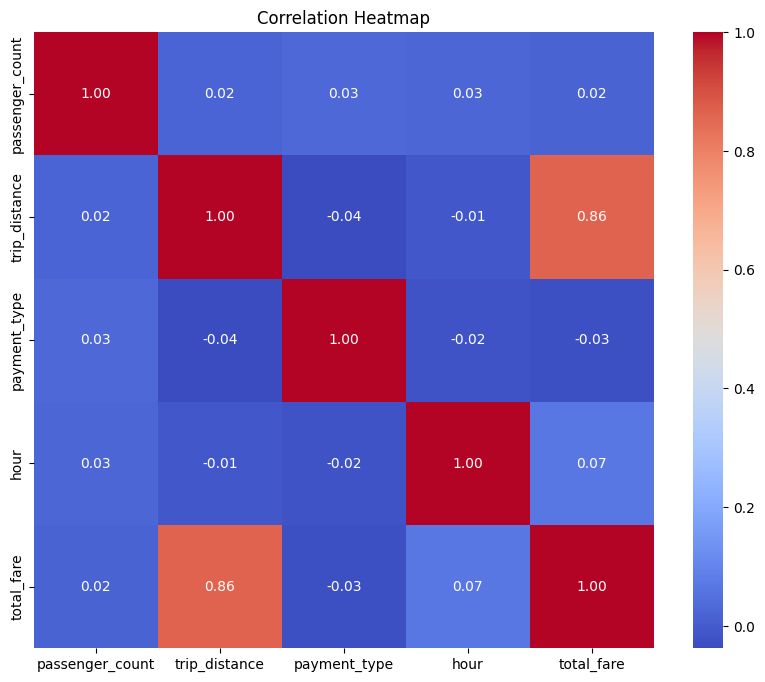

In [ ]:
plt.figure(figsize=(10,8))
corr = df1.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

We can see that the Total Fare depends mainly on the Trip distance .
as trip distance increases , the fare increases.

In [22]:
x = df1.drop("total_fare",axis=1)
y = df1["total_fare"]

In [23]:

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

Using Scaling function to Feature Scale

In [24]:
sc = StandardScaler()
x_scaled = sc.fit_transform(x_train)
x_scale_test = sc.transform(x_test)

Performing Linear Regression

In [25]:
lr = LinearRegression()
model = lr.fit(x_scaled,y_train)
model

LinearRegression()

In [26]:
y_pred = model.predict(x_scale_test)

In [27]:
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: 0.7518843420597685


In [28]:
model.coef_

array([-0.019233  ,  4.8416285 ,  0.02666731,  0.43115531])

In [29]:
x_train1 = sm.add_constant(x_scaled,prepend=False)
mod1 = sm.OLS(y_train,x_train1).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:             total_fare   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 2.984e+05
Date:                Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:59:09   Log-Likelihood:            -9.7003e+05
No. Observations:              396359   AIC:                         1.940e+06
Df Residuals:                  396354   BIC:                         1.940e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0192      0.004     -4.325      0.0

In [30]:
y_pred = mod1.fittedvalues
res = y_pred - y_train

In [33]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

RMSE: 2.4768719164500856
R2 Score: 0.8040476214462184


In [34]:
XGB = xgb.XGBRegressor(n_estimators=200,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,tree_method="hist",device="cuda", random_state=42)
XGB.fit(x_train, y_train)
xgb_model = xgb.XGBRegressor()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:00:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:00:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [38]:
y_pred = XGB.predict(x_test)
y_pred

array([15.928367, 11.086908, 10.189702, ..., 17.339529, 18.767935,
       16.118437], dtype=float32)

In [39]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')


RMSE: 2.396776435175273
R2 Score: 0.8165158756207506


<Figure size 1000x600 with 0 Axes>

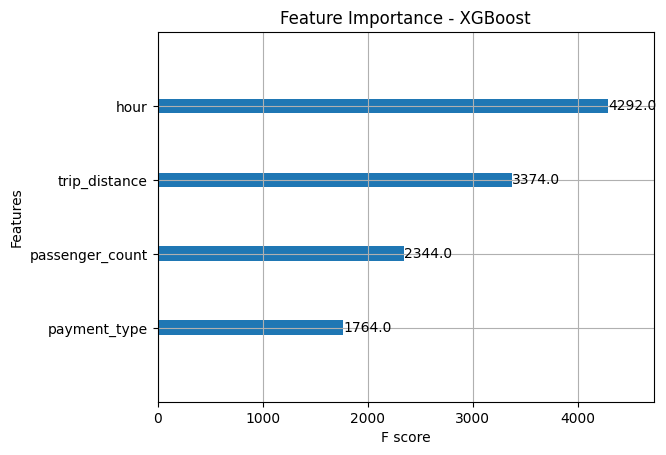

In [40]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(XGB)
plt.title('Feature Importance - XGBoost')
plt.show()


Feature importance tells us which feature are the most useful in predicting the total fare , here we can see that hours , trip distance and number of passenger are the important feature.

**Cross Validation of each model**

In [36]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
lr_scores = cross_val_score(lr, x, y, scoring='r2', cv=kfold)
print("Linear Regression R2 Scores:", lr_scores)
print("Linear Regression Mean R2:", np.mean(lr_scores))

Linear Regression R2 Scores: [0.75188434 0.74863429 0.75181243 0.75138158 0.75110467]
Linear Regression Mean R2: 0.7509634609720907


In [42]:
dt_scores = cross_val_score(rf, x, y, scoring='r2', cv=kfold)

print("Random Forest R2 Scores:", dt_scores)
print("Random Forest Mean R2:", np.mean(dt_scores))

KeyboardInterrupt: 

In [ ]:
xgb_scores = cross_val_score(XGB, x, y, scoring='r2', cv=kfold)

print("XGBoost R2 Scores:", xgb_scores)
print("XGBoost Mean R2:", np.mean(xgb_scores))

XGBoost R2 Scores: [0.81647409 0.81507986 0.81689303 0.81610906 0.81703809]
XGBoost Mean R2: 0.8163188248123101


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGB,
    param_grid=param_grid,
    scoring='r2',       # Or 'neg_root_mean_squared_error' for RMSE
    cv=5,               # 5-fold cross-validation
    verbose=2,          # Progress logs
    n_jobs=-1           # Utilize all CPU cores
)


In [ ]:
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Best R2 Score: 0.8163114499655635


In [ ]:
best_model = grid_search.best_estimator_

# Predict or evaluate further
y_pred = best_model.inplace_predict(x_test)  # If you have a test set


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

RMSE: 2.396166120691429
R2 Score: 0.8166093084160322


1. Linear Regression Mean R2: 0.750963460972091
2. Random Forest Mean R2: 0.8033730972666004
3. XGBoost Mean R2: 0.8163188248123101
   
out of this three models , XGBoost performed well , so we did hyperparameter tuning on XGBoost
giving us
R2 Score: 0.8166093084160322.
we will prefer XgBoost over Linear Regression and Random Forest Regressor , as it capture more variance of the data and helps in reducing the RMSE , and increasing R2 score.